In [1]:
!wmic path win32_VideoController get Caption, DeviceID, VideoProcessor

Caption                         DeviceID          VideoProcessor           

NVIDIA GeForce RTX 3070         VideoController1  NVIDIA GeForce RTX 3070  

Parsec Virtual Display Adapter  VideoController2                           





In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import LSTM
from tensorflow.python.keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.wrappers.scikit_learn import KerasRegressor
# from scikeras.wrappers import KerasRegressor # 回归神经网络
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
# univariate bidirectional lstm example
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Bidirectional
import keras.backend as K
import os
import glob

In [3]:
df = pd.read_csv('../../Data/ProcessedData/sorted_58606.csv', header=None)
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,58606,2840.00,11558.0,264.0,1951,12,1,11.2,4.0,0.00,4.0,88.0,0.0,0.8903
1,58606,2840.00,11558.0,264.0,1951,12,2,14.0,8.0,0.00,4.4,83.0,0.0,1.2308
2,58606,2840.00,11558.0,264.0,1951,12,3,15.1,8.7,0.50,7.0,75.0,0.0,1.8942
3,58606,2840.00,11558.0,264.0,1951,12,4,13.8,4.8,8.10,6.2,78.0,0.0,1.7360
4,58606,2840.00,11558.0,264.0,1951,12,5,11.4,2.3,7.50,3.3,71.0,0.0,1.5499
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24525,58606,28.58,115.9,47.2,2021,8,27,30.5,23.1,2.20,2.1,85.0,31.5,2.8778
24526,58606,28.58,115.9,47.2,2021,8,28,32.7,24.6,3.90,1.0,80.5,999990.0,3.3582
24527,58606,28.58,115.9,47.2,2021,8,29,34.4,26.0,7.35,1.3,76.3,0.0,4.4921
24528,58606,28.58,115.9,47.2,2021,8,30,35.4,27.7,8.10,1.3,74.0,999990.0,4.8488


In [4]:
df = df.iloc[:, 7:]
df

,7,8,9,10,11,12,13
0,11.2,4.0,0.00,4.0,88.0,0.0,0.8903
1,14.0,8.0,0.00,4.4,83.0,0.0,1.2308
2,15.1,8.7,0.50,7.0,75.0,0.0,1.8942
3,13.8,4.8,8.10,6.2,78.0,0.0,1.7360
4,11.4,2.3,7.50,3.3,71.0,0.0,1.5499
...,...,...,...,...,...,...,...
24525,30.5,23.1,2.20,2.1,85.0,31.5,2.8778
24526,32.7,24.6,3.90,1.0,80.5,999990.0,3.3582
24527,34.4,26.0,7.35,1.3,76.3,0.0,4.4921
24528,35.4,27.7,8.10,1.3,74.0,999990.0,4.8488


In [5]:
# 数据范围过大，对数据进行归一化
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

In [6]:
sacler_data_len = len(df.columns)

In [7]:
#数据集划分
def splitData(var, per_test):
    num_test = int(len(var) * per_test)
    train_size = int(len(var) - num_test)
    train_data = var[0:train_size]
    test_data = var[train_size:train_size + num_test]
    return train_data, test_data


df_training, df_testing = splitData(scaled_data, 0.2)
print(df_training.shape)
print(df_testing.shape)

(19624, 7)
(4906, 7)


In [8]:
def createXY(data,n_past,n_steps_out):
    dataX,dataY = list(),list()
    for i in range(len(data)):
        ## such as: len(data) = 19624
        end_ix = i + n_past ## 0+3=3,1+3=4,...,19618+3=19621
        out_end_ix = end_ix + n_steps_out ## 3+3=6,4+3=7,...,19621+3=19624
        # print('out_end_ix:',out_end_ix)
        '''
        加入此处判断，使得最终的dataX和dataY中每行的数组长度一致，进而可以转换为array(数组),如若不加以限制，
        则导致最后几次循环由于i是在len(data)范围内的，
        但是由于out_end_ix=end_ix + n_steps_out,最终会超出data的数据范围，而导致其无法获取到数据,
        加入dataY之后，最后几行的数据长度是和前面的数据长度不一致，最终导致无法进行array转换
        '''
        if out_end_ix > len(data): ## 6 < len(data),7<len(data),...,19623+3=19626>len(data)=19624
            # print("------------out_end_ix of end",out_end_ix,'---------------')
            break

        dataX.append(data[i:end_ix,0:data.shape[1]]) ## 0:3,0:7;1:4,0:7
        dataY.append(data[end_ix:out_end_ix,6]) ##3:6,6;4:7,6
    return array(dataX),array(dataY)

In [9]:
n_past = 1
n_output = 1
trainX,trainY = createXY(df_training,n_past,n_output)
testX,testY = createXY(df_testing,n_past,n_output)

In [10]:
print('train Shape---', trainX.shape)
print('trainY Shape---', trainY.shape)
print('testX Shape---', testX.shape)
print('testY Shape---', testY.shape)

train Shape--- (19623, 1, 7)
trainY Shape--- (19623, 1)
testX Shape--- (4905, 1, 7)
testY Shape--- (4905, 1)


In [11]:
def Result_Ana(Model, feature_num):
    print('Result_Ana_Function:',testX.shape)
    y_pred = Model.predict(testX)
    y_pred = np.array(y_pred).reshape(-1, 1)
    #将一个数组prediction在最后一个轴上（即axis=-1）进行复制，重复8次，并将结果存储在prediction_copies_array数组中
    prediction_copies_array = np.repeat(y_pred, feature_num,axis=-1)
    #prediction_copies_array
    #prediction_copies_array.shape
    pred = scaler.inverse_transform(np.reshape(prediction_copies_array, (len(y_pred), feature_num)))[:,feature_num-1] #进行逆变换但是，只需要最后一列

    # print(pred)
    print('Result_Ana_Function2:',testY.shape)
    original_copies_array = np.repeat(testY, feature_num, axis=-1)
    print('IMF_True:',scaler.inverse_transform(np.reshape(original_copies_array, (len(testY), feature_num))))
    y_true = scaler.inverse_transform(np.reshape(original_copies_array, (len(testY), feature_num)))[:, feature_num-1]
    print('feature_num-1_waterl level_true:',y_true)
    # y_true = scaler.inverse_transform(np.array(testY).reshape(-1,1))

    y_true = y_true[0:len(y_true)-1]
    pred = pred[1:]

    print(pred)
    plt.plot(y_true, color='red', label='Real Value')
    plt.plot(pred, color='blue', label='Pred Value')
    plt.title('Prediction Water Level(m)')
    plt.xlabel('Time (h)')
    plt.ylabel('Water Level(m)')
    plt.legend()
    # plt.savefig('../Images/SW_IN_F_Train_'+'n_past='+'{}'.format((trainX[1].shape)[0])+'_epochs={}'.format((grid_search.best_params_)['epochs'])+'.png',dpi=600)
    plt.show()
    # y_true_data = pd.DataFrame(y)
    # y_true_data.to_csv('../ResultAnaAndProcess/Result/All Features/RF/37390_300/' + 'RF_{}'.format(site_name) + '_True' + '.csv',
    #               index=False)
    # pred_data = pd.DataFrame(pred)
    # pred_data.to_csv('../ResultAnaAndProcess/Result/All Features/RF/37390_300/' + 'RF_{}'.format(site_name) + '_Pre' + '.csv',
    #              index=False)
    from sklearn.metrics import mean_squared_error as mse
    from sklearn.metrics import mean_absolute_error as mae
    from sklearn.metrics import r2_score as r2
    print('MSE:',mse(y_true,pred))
    print('MAE:',mae(y_true,pred))
    print('R²:',r2(y_true,pred))
    print('RMSE:',np.sqrt(mse(y_true,pred)))
    print('pred_finally:',pred)

    return y_true,pred

Epoch 1/30


<timed exec>:12: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


307/307 [==============================] - 2s 2ms/step - loss: 0.0172 - accuracy: 0.0000e+00
Epoch 2/30
307/307 [==============================] - 0s 1ms/step - loss: 0.0104 - accuracy: 0.0000e+00
Epoch 3/30
307/307 [==============================] - 0s 1ms/step - loss: 0.0101 - accuracy: 0.0000e+00
Epoch 4/30
307/307 [==============================] - 0s 1ms/step - loss: 0.0101 - accuracy: 0.0000e+00
Epoch 5/30
307/307 [==============================] - 0s 2ms/step - loss: 0.0100 - accuracy: 0.0000e+00
Epoch 6/30
307/307 [==============================] - 0s 2ms/step - loss: 0.0099 - accuracy: 0.0000e+00
Epoch 7/30
307/307 [==============================] - 0s 1ms/step - loss: 0.0099 - accuracy: 0.0000e+00
Epoch 8/30
307/307 [==============================] - 0s 1ms/step - loss: 0.0098 - accuracy: 0.0000e+00
Epoch 9/30
307/307 [==============================] - 0s 1ms/step - loss: 0.0097 - accuracy: 0.0000e+00
Epoch 10/30
307/307 [==============================] - 0s 1ms/step - loss: 

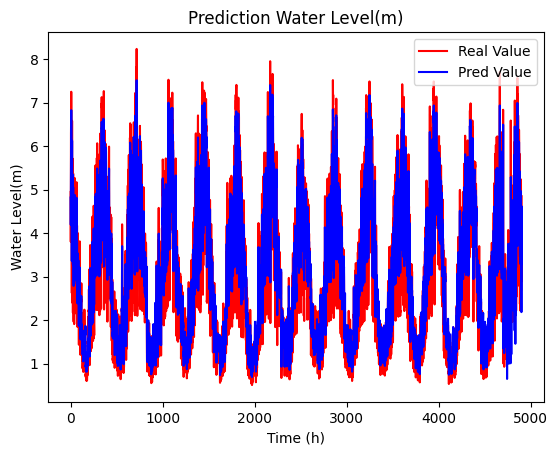

MSE: 0.22477259762820453
MAE: 0.38571012869462296
R²: 0.9261148568771956
RMSE: 0.47410188528227193
pred_finally: [4.818577  4.1931415 4.9933634 ... 2.1828659 4.618746  3.2948747]
prediction_result: [4.818577  4.1931415 4.9933634 ... 2.1828659 4.618746  3.2948747]
lstm_y_turs: [4.947  3.8    5.3882 ... 3.3582 4.4921 4.8488]
CPU times: total: 17min 34s
Wall time: 5min 2s


In [12]:
%%time
def BiLSTM(optimizer='adam', batch_size=32, epochs=40):
    model = Sequential()
    model.add(Bidirectional(LSTM(100, activation='relu', input_shape=(n_past, sacler_data_len))))
    # optimizer = Adam()  # 设置为您希望的学习率
    model.add(Dropout(0.1))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mse', metrics='accuracy')
    return model


# N_LSTM_Model = KerasRegressor(N_LSTM, epochs=40, verbose=1, validation_data=(testX, testY))
BiLSTM_Model = KerasRegressor(BiLSTM, epochs=40, verbose=1)

from sklearn.model_selection import GridSearchCV

# 定义超参数搜索范围
param_grid = {
    'optimizer': ['adam'],
    'batch_size': [32, 64, 128],
    'epochs': [30, 40, 50]
}

# 执行网格搜索
grid = GridSearchCV(estimator=BiLSTM_Model, param_grid=param_grid, cv=2)
grid_result = grid.fit(trainX, trainY)

best_model = grid_result.best_estimator_

y_trues, prediction_result = Result_Ana(best_model, sacler_data_len)

print('prediction_result:', prediction_result)
# finally_rsult.append(prediction_result)
print('lstm_y_turs:', y_trues)
# finally_y_true.append(y_trues)

# Q: 使用GPU计算

Result_Ana_Function: (4905, 1, 7)
154/154 [==============================] - 0s 972us/step
Result_Ana_Function2: (4905, 1)
IMF_True: [[2.02576525e+01 1.27204730e+01 7.16586547e+00 ... 6.38866191e+01
  5.42868596e+05 4.94700000e+00]
 [1.43096887e+01 7.20022794e+00 5.40152564e+00 ... 5.33273125e+01
  4.09206488e+05 3.80000000e+00]
 [2.25455703e+01 1.48438663e+01 7.84452871e+00 ... 6.79483158e+01
  5.94282478e+05 5.38820000e+00]
 ...
 [1.78986911e+01 1.05311448e+01 6.46612860e+00 ... 5.96988000e+01
  4.89858227e+05 4.49210000e+00]
 [1.97484197e+01 1.22478592e+01 7.01481214e+00 ... 6.29825878e+01
  5.31425162e+05 4.84880000e+00]
 [2.45752416e+01 1.67275838e+01 8.44658853e+00 ... 7.15515526e+01
  6.39893070e+05 5.77960000e+00]]
feature_num-1_waterl level_true: [4.947  3.8    5.3882 ... 4.4921 4.8488 5.7796]
[4.844431  4.2400475 5.1136765 ... 2.0403967 4.655665  3.0974998]


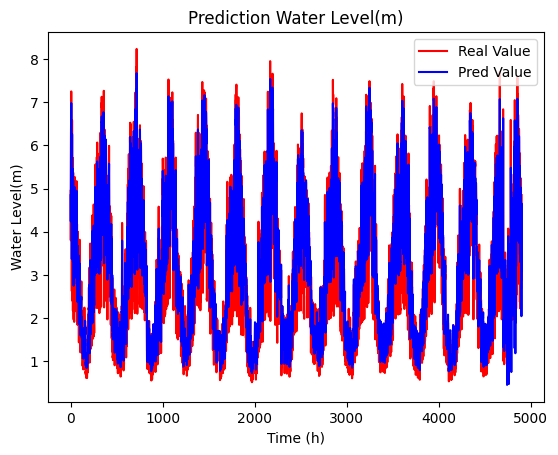

MSE: 0.21184706700074754
MAE: 0.36020825152138125
R²: 0.9303636162474438
RMSE: 0.460268472742537
pred_finally: [4.844431  4.2400475 5.1136765 ... 2.0403967 4.655665  3.0974998]


In [17]:
y_trues, prediction_result = Result_Ana(best_model, sacler_data_len)